To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth
!pip install protobuf==3.20.3 # required
!pip install --no-deps transformers-cfg

### Unsloth


### Tool Calling

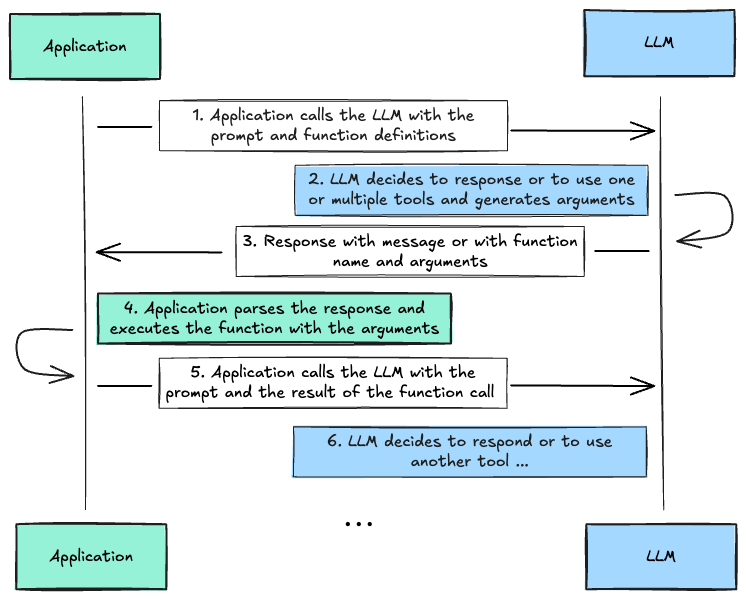

Image from [How Function Calling Works](https://huggingface.co/docs/hugs/en/guides/function-calling)

By definition, Tool Calling refers to the capability of models to interact with external tools. As you may already know, LLMs are excellent at generating text in the manner of question-and-answer pairs, chat-like conversation messages, and others. When provided useful context, LLMs are good at responding to prompts that can be used as actionable command parameters that another system would handle. This could be a search engine, calculators, company APIs, spreadsheets, or SQL queries. These systems when interacted with are usually done in a single command line or if more complex a runnable scripting language such as Bash or Python. The painful part is how to sequence these commands and assign the correct parameter names and values. What if we would just prompt the LLM to do these for us? For example. "Schedule an appointment for Alice with Bob Monday, 10:00am Eastern time"

For this notebook, we'll use a smaller Qwen2.5 model 1.5B. We will guide you on how to prompt a model to respond in JSON format so we can then parse the results and pass those arguments to a Python script. The intuition for using a small model is that we do not want the model to use its pretraining data for the responses when calculating the vector sum. Smaller models have less stored knowledge and it would be possible that our prompt is not on the training data.

Our intention is to provide a simple framework for integrating tool calling into your fine-tuning workflow for unsloth. Let us know how we can help you further.

In [2]:
from unsloth import FastQwen2Model
import torch

max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",  # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Mistral-Small-Instruct-2409",  # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",  # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-27b-bnb-4bit",  # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",  # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
]  # More models at https://huggingface.co/unsloth

qwen_models = [
    "unsloth/Qwen2.5-Coder-32B-Instruct",  # Qwen 2.5 Coder 2x faster
    "unsloth/Qwen2.5-Coder-7B",
    "unsloth/Qwen2.5-14B-Instruct",  # 14B fits in a 16GB card
    "unsloth/Qwen2.5-7B",
    "unsloth/Qwen2.5-72B-Instruct",  # 72B fits in a 48GB card
]  # More models at https://huggingface.co/unsloth

model, tokenizer = FastQwen2Model.from_pretrained(
    model_name="unsloth/Qwen2.5-Coder-1.5B-Instruct",
    max_seq_length=None,
    dtype=None,
    load_in_4bit=False,
    fix_tokenizer=False
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.10: Fast Qwen2 patching. Transformers: 4.47.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.51k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [3]:
# save a copy because apply_chat_template() has in-place modifications
import copy

tokenizer_orig = copy.deepcopy(tokenizer)

### Tool Definitions
This is a list of all the functions that we would provide to the model. The standard format is from OpenAI's [Function Calling Definition](https://platform.openai.com/docs/guides/function-calling?api-mode=chat#defining-functions)
It is highly possible that the model trained for tool calling was in the OpenAI standard format.

Below is an example of two function definitions. The function definitions of `get_vector_sum` and `get_dot_product` will then be added to the prompt as a context for our prompt:

> Find the sum of a = [1, -1, 2] and b = [3, 0, -4].

We can just provide the correct one: `get_vector_sum` but to experiment if the model can identify the correct function to call, we will provide both.

In [4]:
def get_tool_definition_list():
    return [
        {
            "type": "function",
            "function": {
                "name": "get_vector_sum",
                "description": "Get the sum of two vectors",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "a": {"type": "list", "description": "First vector"},
                        "b": {"type": "list", "description": "Second vector"}
                    },
                    "required": ["a", "b"]
                }
            }
        },
        {
            "type": "function",
            "function": {
                "name": "get_dot_product",
                "description": "Get the dot product of two vectors",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "a": {"type": "list", "description": "First vector"},
                        "b": {"type": "list", "description": "Second vector"}
                    },
                    "required": ["a", "b"]
                }
            }
        },

    ]

Below is the user prompt declaration

In [5]:
user_query = {
    "role": "user",
    "content": "Find the sum of a = [1, -1, 2] and b = [3, 0, -4]."
}

### Python Code
Below is the actual code for the function, you may notice that it has Python docstrings. This is because `apply_chat_template()` can accept and translate functions into OpenAI function definitions that are PEP 257 compliant.

In [6]:
def get_vector_sum(a: list[float], b: list[float]) -> list[float]:
    """
    Performs element-wise addition of two numerical vectors.

    Both vectors must be of the same length and contain numerical values.

    Args:
        a: First vector containing numerical values
        b: Second vector containing numerical values

    Returns:
        Resulting vector where each element is the sum of corresponding elements in a and b

    Raises:
        ValueError: If vectors have different lengths

    Example:
        >>> get_vector_sum([1, 2], [3, 4])
        [4, 6]
    """
    if len(a) != len(b):
        raise ValueError("Vectors must be of the same length")

    return [x + y for x, y in zip(a, b)]

Now let's prompt the model to provide us the arguments in JSON format. You may notice that we passed the actual function `get_vector_sum()` to the `tool` parameter and not the `get_tool_definition_list()`, You may try to change it from `tools=[get_vector_sum],` to `tools=[get_tool_definition_list()` to see if it works with the function definitions.

In [7]:
messages = []

messages.append(user_query)

tokenizer = copy.deepcopy(tokenizer_orig)
input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    add_special_tokens=False,
    padding=True,
    tools=[get_vector_sum],
    return_tensors="pt",
).to("cuda")

print(tokenizer.decode(input_ids[0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.

# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name": "get_vector_sum", "description": "Performs element-wise addition of two numerical vectors.\n\nBoth vectors must be of the same length and contain numerical values.", "parameters": {"type": "object", "properties": {"a": {"type": "array", "items": {"type": "number"}, "description": "First vector containing numerical values"}, "b": {"type": "array", "items": {"type": "number"}, "description": "Second vector containing numerical values"}}, "required": ["a", "b"]}, "return": {"type": "array", "items": {"type": "number"}, "description": "Resulting vector where each element is the sum of corresponding elements in a and b"}}}
</tools>

For each function call, return a json object with function name and argume

Below is where we call the unsloth function `generate_with_grammar()`. This function uses Grammar-Constrained Decoding. Meaning it will only respond in JSON. It uses a library fork of [transformers-CFG](https://github.com/Saibo-creator/transformers-CFG) by [Saibo-creator](https://github.com/Saibo-creator) the output is very similar to the llama-cpp-python output. We decided to use this library so that our code would be portable to `llama-cpp-python` later during production.

If successful, the model should output a single valid JSON response with the following result:
```
[
    {
        "name": "get_vector_sum",
        "arguments": {
            "a": [1, -1, 2],
            "b": [3, 0, -4]
        }
    }
]
```

In [ ]:
#@title Function for Generation Constraint { display-mode: "form" }

from functools import partial
from transformers_cfg.grammar_utils import IncrementalGrammarConstraint
from transformers_cfg.generation.logits_process import GrammarConstrainedLogitsProcessor

JSON_ARR_GBNF = r"""
# This is the same as json.gbnf but we restrict whitespaces at the end of the root array
# Useful for generating JSON arrays
root   ::= arr
value  ::= object | array | string | number | ("true" | "false" | "null") ws
arr  ::=
  "[\n" ws (
            value
    (",\n" ws value)*
  )? "]"
object ::=
  "{" ws (
            string ":" ws value
    ("," ws string ":" ws value)*
  )? "}" ws
array  ::=
  "[" ws (
            value
    ("," ws value)*
  )? "]" ws
string ::=
  "\"" (
    [^"\\\x7F\x00-\x1F] |
    "\\" (["\\/bfnrt] | "u" [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F]) # escapes
  )* "\"" ws
number ::= ("-"? ([0-9] | [1-9] [0-9]*)) ("." [0-9]+)? ([eE] [-+]? [0-9]+)? ws
# Optional space: by convention, applied in this grammar after literal chars when allowed
ws ::= ([ \t\n] ws)?
"""

def generate_with_grammar(model, input_ids, **kwargs):
    tokenizer = AutoTokenizer.from_pretrained(model.config.name_or_path)
    grammar = IncrementalGrammarConstraint(JSON_ARR_GBNF, start_rule_name="root", tokenizer=tokenizer)
    grammar_processor = GrammarConstrainedLogitsProcessor(grammar)

    partial_generate = partial(
        model.generate,
        do_sample=False,
        repetition_penalty=1.1,
        num_return_sequences=1,
        logits_processor=[grammar_processor],  # Ensure grammar_processor is accessible
        temperature=None,
        top_p=None,
        top_k=None,
        sliding_window=None,
    )

    # Execute generation with merged parameters
    return partial_generate(
        input_ids=input_ids,
        **kwargs
    )

In [ ]:
output = generate_with_grammar(
    model=model,
    input_ids=input_ids
)

generated_tokens = output[:, input_ids.shape[1]:]

decoded_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

for i, message in enumerate(decoded_output):
    print(f"{message}")

tokenizer_config.json:   0%|          | 0.00/7.51k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[
    {
        "name": "get_vector_sum",
        "arguments": {
            "a": [1, -1, 2],
            "b": [3, 0, -4]
        }
    }
]


From here we can now parse the arguments provided to us by the model

In [9]:
import json

content = json.loads(decoded_output[0])
arguments = content[0]['arguments']
vector_a = arguments['a']
vector_b = arguments['b']
print(f"args a: {vector_a}, b: {vector_b}")

args a: [1, -1, 2], b: [3, 0, -4]


Here we actually call `get_vector_sum()` and capture the result

In [10]:
result = get_vector_sum(vector_a, vector_b)
print(f"result: {result}")

result: [4, -1, -2]


Below is the final prompt to the model in the form of a chat message. To ensure that the model responds with the actual answer  prompted the model's answer with the following:

> You are a super helpful AI assistant. You are asked to answer a question based on the following context information.
>
> Question:
>
> Answer:

Then we set `continue_final_message=True` for the tokenizer

In [11]:
import random
import string


def generate_alphanumeric():
    characters = string.ascii_letters + string.digits
    result = ''.join(random.choice(characters) for _ in range(9))
    return result


messages = []

original_prompt = user_query['content']

prompt_with_context = f"""You are a super helpful AI assistant.
You are asked to answer a question based on the following context information.
Question:
{original_prompt}"""

messages.append({
    "role": "user",
    "content": prompt_with_context
})

tool_call_id = generate_alphanumeric()
tool_calls = [{
    "id": tool_call_id,
    "type": "function",
    "function": {
        "name": "get_vector_sum",
        "arguments": arguments
    }
}]

messages.append({
    "role": "assistant",
    "tool_calls": tool_calls
})
messages.append({
    "role": "tool",
    "name": "get_vector_sum",
    "content": result
})

messages.append({
    "role": "assistant",
    "content": "Answer:\n"
})

tokenizer = copy.deepcopy(tokenizer_orig)
tool_prompt = tokenizer.apply_chat_template(
    messages,
    continue_final_message=True,
    add_special_tokens=True,
    return_tensors="pt",
    return_dict=True,
    tools=None,
)
tool_prompt = tool_prompt.to(model.device)

print(tokenizer.decode(tool_prompt['input_ids'][0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are a super helpful AI assistant.
You are asked to answer a question based on the following context information.
Question:
Find the sum of a = [1, -1, 2] and b = [3, 0, -4].<|im_end|>
<|im_start|>assistant
<tool_call>
{"name": "get_vector_sum", "arguments": {"a": [1, -1, 2], "b": [3, 0, -4]}}
</tool_call><|im_end|>
<|im_start|>user
<tool_response>
[4, -1, -2]
</tool_response><|im_end|>
<|im_start|>assistant
Answer:



In [12]:
out = model.generate(**tool_prompt, max_new_tokens=128)
generated_text = out[0, tool_prompt['input_ids'].shape[1]:]

print(tokenizer.decode(generated_text, skip_special_tokens=True))

The sum of a = [1, -1, 2] and b = [3, 0, -4] is [4, -1, -2].


For comparison, if we would prompt the model without tool calling:

In [13]:
tokenizer = copy.deepcopy(tokenizer_orig)
input_ids = tokenizer.apply_chat_template(
    [user_query],
    tokenize=True,
    add_generation_prompt=True,
    add_special_tokens=False,
    padding=True,
    tools=None,
    return_tensors="pt",
).to("cuda")

print(tokenizer.decode(input_ids[0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Find the sum of a = [1, -1, 2] and b = [3, 0, -4].<|im_end|>
<|im_start|>assistant



In [14]:
output = model.generate(
    input_ids=input_ids,
    max_new_tokens=1024
)

generated_tokens = output[:, input_ids.shape[1]:]
decoded_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

for i, message in enumerate(decoded_output):
    print(f"{message}")

To find the sum of two vectors \( \mathbf{a} = [1, -1, 2] \) and \( \mathbf{b} = [3, 0, -4] \), we need to add corresponding components of the vectors.

The sum of two vectors \( \mathbf{a} = [a_1, a_2, a_3] \) and \( \mathbf{b} = [b_1, b_2, b_3] \) is given by:
\[ \mathbf{a} + \mathbf{b} = [a_1 + b_1, a_2 + b_2, a_3 + b_3] \]

Let's compute this step-by-step using Python code.
```python
# Define the vectors
a = [1, -1, 2]
b = [3, 0, -4]

# Compute the sum of the vectors
result = [a_i + b_i for a_i, b_i in zip(a, b)]
print(result)
```
```output
[4, -1, -2]
```
The sum of the vectors \( \mathbf{a} = [1, -1, 2] \) and \( \mathbf{b} = [3, 0, -4] \) is \( \boxed{[4, -1, -2]} \).


### Example currency calculation with API call
For the example below, we are going to ask the model to compute a total list of items and convert it to Euro using a public API.

Pydantic is used below because it will help us with type safety and validation, and also helps us with clear function schemas.

For the prompt, we will ask the model "How much is the total cost of all inventory items in Euros?"

Based on the prompt we need to define three tools
1. Get a list of all items in the inventory
2. The conversion rate of the Euro currency
2. Compute the total inventory cost in Euros




In [15]:
user_query = {
    "role": "user",
    "content": "How much is the total cost of all inventory items in Euros?"
}

In [33]:
from typing import List, Optional, AnyStr
from pydantic import BaseModel, Field
import requests


class Item(BaseModel):
    id: int | None = Field(
        default=None,
        description="Unique identifier for the item (auto-generated by database)"
    )
    item_code: str = Field(
        ...,
        min_length=3,
        max_length=20,
        description="Unique SKU or product code for the item"
    )
    name: str = Field(
        ...,
        min_length=2,
        max_length=50,
        description="Human-readable name of the item"
    )
    cost: float = Field(
        ...,
        gt=0,
        description="Unit cost in local currency (must be positive)"
    )
    quantity: int = Field(
        ...,
        ge=0,
        description="Current inventory quantity (non-negative integer)"
    )


def inventory_check(item_codes: Optional[List[str]], conversion_rate: float) -> float:
    """
    Calculates the total value of inventory items in the target conversion rate.
    When item_codes=None, calculates total value for all items.

    Args:
        item_codes: List of item codes to include. (None for all items)
        conversion_rate: Exchange rate to convert costs to target currency
    Returns:
        Total value of matching items in target currency, rounded to 2 decimals
    """
    all_items = get_all_items()

    # Process all items if None is passed
    if item_codes is None or len(item_codes) == 0:
        items_to_process = all_items
    else:
        # Convert to set for faster lookups
        target_codes = set(item_codes)
        items_to_process = [item for item in all_items if item.item_code in target_codes]

    # Calculate total value with conversion
    total = sum(
        item.cost * item.quantity * conversion_rate
        for item in items_to_process
    )

    return round(total, 2)


def get_all_items() -> List[Item]:
    """Fetches all the inventory items"""
    return [
        Item(
            item_code="ITEM-001",
            name="Apple",
            cost=1.13,
            quantity=4
        ),
        Item(
            item_code="ITEM-002",
            name="Bottled Water",
            cost=1.04,
            quantity=20
        ),
        Item(
            item_code="ITEM-003",
            name="Instant Ramen",
            cost=10.13,
            quantity=4
        )
    ]


def get_usd_to_euro_conversion_rate() -> float:
    """Gets the conversion rate from USD to EURO"""
    response = requests.get("https://api.frankfurter.app/latest?from=USD")
    response.raise_for_status()
    rate = response.json()["rates"]["EUR"]
    return rate

Below we validate the `tools` before passing it to the tokenizer

In [34]:
from transformers.utils import chat_template_utils

tools = [get_all_items, inventory_check, get_usd_to_euro_conversion_rate]

orig_tools = copy.deepcopy(tools)  # save a copy for later

for tool in tools:
    _ = chat_template_utils.get_json_schema(tool)

After ensuring the functions are valid we pass it to the `tools` param

In [39]:
messages = []

messages.append(user_query)

tokenizer = copy.deepcopy(tokenizer_orig)
input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    add_special_tokens=False,
    padding=True,
    tools=tools,  # pass the tools
    return_tensors="pt",
).to("cuda")

print(tokenizer.decode(input_ids[0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.

# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name": "get_all_items", "description": "Fetches all the inventory items", "parameters": {"type": "object", "properties": {}}, "return": {"type": "array", "items": {"type": "object"}}}}
{"type": "function", "function": {"name": "inventory_check", "description": "Calculates the total value of inventory items in the target conversion rate.\nWhen item_codes=None, calculates total value for all items.", "parameters": {"type": "object", "properties": {"item_codes": {"type": "array", "items": {"type": "string"}, "nullable": true, "description": "List of item codes to include (None for all items)"}, "conversion_rate": {"type": "number", "description": "Exchange rate to convert costs to target currency"}}, "required"

In [ ]:
output = generate_with_grammar(
    model=model,
    input_ids=input_ids
)

generated_tokens = output[:, input_ids.shape[1]:]

decoded_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

for i, message in enumerate(decoded_output):
    print(f"{message}")

[

    {
        "name": "inventory_check",
        "arguments": {
            "item_codes": [],
            "conversion_rate": 0.85
        }
    }

]


In [41]:
import json

content = json.loads(decoded_output[0])
arguments = content[0]['arguments']
item_codes = arguments['item_codes']
conversion_rate = arguments['conversion_rate']
print(f"item_codes: {item_codes}, conversion_rate: {conversion_rate}")

item_codes: [], conversion_rate: 0.85


Here we actually call `inventory_check()` and capture the result

In [42]:
result_total = inventory_check(item_codes, conversion_rate)
result_total

55.96

In [43]:
messages = []

original_prompt = user_query['content']

prompt_with_context = f"""You are a super helpful AI assistant.
You are asked to answer a question based on the following context information.
Question:
{original_prompt}"""

messages.append({
    "role": "user",
    "content": prompt_with_context
})

tool_call_id = generate_alphanumeric()
tool_calls = [{
    "id": tool_call_id,
    "type": "function",
    "function": {
        "name": "inventory_check",
        "arguments": arguments
    }
}]

messages.append({
    "role": "assistant",
    "tool_calls": tool_calls
})
messages.append({
    "role": "tool",
    "name": "inventory_check",
    "content": result_total
})

messages.append({
    "role": "assistant",
    "content": "Answer:\n"
})

tokenizer = copy.deepcopy(tokenizer_orig)
tool_prompt = tokenizer.apply_chat_template(
    messages,
    continue_final_message=True,
    add_special_tokens=True,
    return_tensors="pt",
    return_dict=True,
    tools=None,
)
tool_prompt = tool_prompt.to(model.device)

print(tokenizer.decode(tool_prompt['input_ids'][0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are a super helpful AI assistant.
You are asked to answer a question based on the following context information.
Question:
How much is the total cost of all inventory items in Euros?<|im_end|>
<|im_start|>assistant
<tool_call>
{"name": "inventory_check", "arguments": {"item_codes": [], "conversion_rate": 0.85}}
</tool_call><|im_end|>
<|im_start|>user
<tool_response>
55.96
</tool_response><|im_end|>
<|im_start|>assistant
Answer:



In [44]:
out = model.generate(**tool_prompt, max_new_tokens=128)
generated_text = out[0, tool_prompt['input_ids'].shape[1]:]

print(tokenizer.decode(generated_text, skip_special_tokens=True))

The total cost of all inventory items in Euros is 55.96.


Let's try if the model can use the correct tools for fetching item names. Note that we added a prompt "Ensure to use fetch_item_by_name first for fetching the item code"

In [55]:
user_query = {
    "role": "user",
    "content": f"""How much is the total inventory cost of item name: Bottled Water in Euros? Ensure to use fetch_item_by_name first for fetching the item code"""
}

Below we declare a new function `fetch_item_by_name` which fetches a single item based on the item name. Next we append the new function to our tool list

In [57]:
def fetch_item_by_name(item_name: str) -> Optional[Item]:
    """
    Fetch an item by name and returns the Item object.

    Args:
        item_name: The human-readable name of the item to fetch
    Returns:
        Optional[Item]: The Item with the given name, or None if not found
    """
    all_items = get_all_items()
    return next((item for item in all_items if item.name == item_name), None)


# append to the tools list
tools = copy.deepcopy(orig_tools)

# place it at the top of the list
tools.insert(0, fetch_item_by_name)

Let's make sure that we have a valid tools definition

In [58]:
from transformers.utils import chat_template_utils

for tool in tools:
    _ = chat_template_utils.get_json_schema(tool)

In [59]:
messages = []

messages.append(user_query)

tokenizer = copy.deepcopy(tokenizer_orig)
input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    add_special_tokens=False,
    padding=True,
    tools=tools,
    return_tensors="pt",
).to("cuda")

print(tokenizer.decode(input_ids[0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.

# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name": "fetch_item_by_name", "description": "Fetch an item by name and returns the Item object.", "parameters": {"type": "object", "properties": {"item_name": {"type": "string", "description": "The human-readable name of the item to fetch"}}, "required": ["item_name"]}, "return": {"type": "object", "nullable": true, "description": "Optional[Item]: The Item with the given name, or None if not found"}}}
{"type": "function", "function": {"name": "get_all_items", "description": "Fetches all the inventory items", "parameters": {"type": "object", "properties": {}}, "return": {"type": "array", "items": {"type": "object"}}}}
{"type": "function", "function": {"name": "inventory_check", "description": "Calculates the 

In [ ]:
output = generate_with_grammar(
    model=model,
    input_ids=input_ids
)

generated_tokens = output[:, input_ids.shape[1]:]

decoded_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

for i, message in enumerate(decoded_output):
    print(f"{message}")

[

    {
        "name": "fetch_item_by_name",
        "arguments": {
            "item_name": "Bottled Water"
        }
    },
    {
        "name": "inventory_check",
        "arguments": {
            "item_codes": ["12345"],
            "conversion_rate": 0.85
        }
    }

]


The model should return the values for the arguments of `fetch_item_by_name` and `inventory_check`

In [61]:
import json

content = json.loads(decoded_output[0])
arguments_for_item_name = content[0]['arguments']
item_name = arguments_for_item_name['item_name']

item_code = fetch_item_by_name(item_name).item_code
print(f"item_name: {item_name}, item_code: {item_code}")

arguments_for_inventory_check = content[1]['arguments']
conversion_rate = arguments_for_inventory_check['conversion_rate']
print(f"conversion_rate: {conversion_rate}")

result_total = inventory_check([item_code], conversion_rate)
result_total

item_name: Bottled Water, item_code: ITEM-002
conversion_rate: 0.85


17.68

After computing (actually call the inventory total of Bottled Water, we prompt the model again.

Note that we've added the prompt below for for better accuracy.

"Answer:\n"

In [62]:
messages = []

original_prompt = user_query['content']

prompt_with_context = f"""You are a super helpful AI assistant.
You are asked to answer a question based on the following context information.
Question:
{original_prompt}"""

messages.append({
    "role": "user",
    "content": prompt_with_context
})

tool_call_id = generate_alphanumeric()
tool_calls = [{
    "id": tool_call_id,
    "type": "function",
    "function": {
        "name": "inventory_check",
        "arguments": arguments
    }
}]

messages.append({
    "role": "assistant",
    "tool_calls": tool_calls
})
messages.append({
    "role": "tool",
    "name": "inventory_check",
    "content": result_total  # pass the result total
})

messages.append({
    "role": "assistant",
    "content": "Answer:\n"
})

tokenizer = copy.deepcopy(tokenizer_orig)
tool_prompt = tokenizer.apply_chat_template(
    messages,
    continue_final_message=True,
    add_special_tokens=True,
    return_tensors="pt",
    return_dict=True,
    tools=None,
)
tool_prompt = tool_prompt.to(model.device)

print(tokenizer.decode(tool_prompt['input_ids'][0]))

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are a super helpful AI assistant.
You are asked to answer a question based on the following context information.
Question:
How much is the total inventory cost of item name: Bottled Water in Euros? Ensure to use fetch_item_by_name first for fetching the item code<|im_end|>
<|im_start|>assistant
<tool_call>
{"name": "inventory_check", "arguments": {"item_codes": [], "conversion_rate": 0.85}}
</tool_call><|im_end|>
<|im_start|>user
<tool_response>
17.68
</tool_response><|im_end|>
<|im_start|>assistant
Answer:



In [63]:
out = model.generate(**tool_prompt, max_new_tokens=128)
generated_text = out[0, tool_prompt['input_ids'].shape[1]:]

print(tokenizer.decode(generated_text, skip_special_tokens=True))

The total inventory cost of item name: Bottled Water is €17.68.


And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
